In [1]:
from pandas import DataFrame, read_csv
import plotting_functions as pf
import numpy as np

import sys
import os
sys.path.insert(0, os.path.abspath('../forestpy/forestpy'))

import forest
from importlib import reload
reload(forest)

reload(pf)

import matplotlib.pyplot as plt

def update_grade_cols(grades_file, hp_cols=['estimators', 'md', 'mf', 'mln', 'msl','mss', 'ms']):
    
    if type(grades_file) is str:
        grades = read_csv(grades_file, index_col=0)
    else:
        grades = grades_file
    
    for hp in hp_cols:
        grades[hp] = None
    grades['tdp'] = None
    for i in grades.index:
    #     print(i[:-7].split('_'))

        name = '_'.join(i.split('_')[1:]).replace('.joblib','.yml')
    #     print(name)
        hyperparams = forest.RFParams(name)         
        #add cols

        for hp in hp_cols:
            try:
                hpn = hyperparams.name_substitutions[hp]
            except KeyError:
                hpn = hp
            grades[hp][i] = hyperparams[hpn]
        
        if name.split('_')[-1][:3]=='tdp':
            grades['tdp'][i] = int(name.split('_')[-1].replace('.yml','').replace('tdp',''))
    
    return grades



In [2]:
acp_stats = read_csv('../results/sa-ACP-results/ACP_sa_hyper_all.csv', index_col=0)
acp_stats = update_grade_cols(acp_stats)

sp_stats = read_csv('../results/sa-SP-results/SP_sa_hyperparam_results-labeled.csv', index_col=0)

sp_stats = update_grade_cols(sp_stats)

import math

sp_stats['mf2'] = sp_stats['mf']
sp_stats['mf2'][sp_stats['mf2'] == 'auto'] = 13
sp_stats['mf2'][sp_stats['mf2'] == 'sqrt'] = math.sqrt(13)
sp_stats['mf2'][sp_stats['mf2'] == 'log2'] = math.log2(13)

sp_stats['mf2'] = sp_stats['mf2'].astype(float)
sp_stats['hp_changed'][sp_stats['hp_changed'] == 'mf']  = 'mf2'
sp_stats['e'] = sp_stats['estimators']

acp_stats['mf2'] = acp_stats['mf']
acp_stats['mf2'][acp_stats['mf2'] == 'auto'] = 13
acp_stats['mf2'][acp_stats['mf2'] == 'sqrt'] = math.sqrt(13)
acp_stats['mf2'][acp_stats['mf2'] == 'log2'] = math.log2(13)

acp_stats['mf2'] = acp_stats['mf2'].astype(float)
acp_stats['hp_changed'][acp_stats['hp_changed'] == 'mf'] = 'mf2'
acp_stats['e'] = acp_stats['estimators']

In [3]:
#font sizes
axis_size = 40
legend_size = 30
title_size = 50

label_size=30

# symbol sizes
scatter_size = 200

# fig sizes
figure_size = (20,20)


name_lookup = {
    'mln': 'Maximum Leaf Nodes',
    'r2': '$R^2$',
    'mean_abs_error': "Mean Absolute Error",
    'mae':  "Mean Absolute Error",
    'mae_short':  "MAE",
    'mf': 'Maximum Decision Features',
    'mf2': 'Maximum Decision Features',
    'md': "Maximum Tree Depth",
    'mss': 'Minimum Samples for Split',
    'msl': 'Minimum Samples for Leaf',
    'tdp': 'Percent Data for Training',
    'e': 'Estimators'
}

In [4]:

def basic_title(ax, x,y):
    ax.set_title(name_lookup[y] + ' Sensitivity Analysis - ' + name_lookup[x], fontsize=title_size)

    
def inverted_presntation_plot(x, y, bp_fig_size=figure_size, legend_loc='lower left', axis_bounds=None):
    if type(axis_bounds) is list:
        axis_bounds = [axis_bounds[2], axis_bounds[3], axis_bounds[0], axis_bounds[1]]
    return basic_presentation_plot(y, x,  bp_fig_size, legend_loc, axis_bounds, True)
    
def basic_presentation_plot (x, y, bp_fig_size=figure_size, legend_loc='upper left', axis_bounds=None, invert=False):
    
    reload(pf)
    if not invert:
        idx = acp_stats['hp_changed']==y
    else:
        idx = acp_stats['hp_changed']==x
        
    base_idx = acp_stats['hp_changed']=='base'


    fig, ax = None, None

    fig, ax = pf.scatter(
        acp_stats[idx], x,y, label= 'Arctic Costal Plain', color='tab:blue',
        markersize=scatter_size, figsize=bp_fig_size
    )
    
    fig, ax = pf.scatter(
        acp_stats[base_idx], x,y, color='tab:blue',
        markersize=scatter_size*3.5, figsize=bp_fig_size, ax = ax, fig=fig, symbol='*'
    )


    if not invert:
        idx = sp_stats['hp_changed']==y
    else:
        idx = sp_stats['hp_changed']==x
    
    base_idx = sp_stats['hp_changed']=='base'

    fig, ax = pf.scatter(
        sp_stats[idx], x,y, color='tab:red', ax = ax, fig=fig, label='Seward Peninsula',
        markersize=scatter_size
    )


    fig, ax = pf.scatter(
        sp_stats[base_idx], x,y, color='tab:red',
        markersize=scatter_size*3.5, figsize=bp_fig_size, ax = ax, fig=fig, symbol='*'
    )
    
    ax.legend(loc = legend_loc, fontsize=legend_size)

    if not axis_bounds is None:
        ax.axis(axis_bounds)


    ax.set_ylabel(name_lookup[y], fontsize=axis_size)
    ax.set_xlabel(name_lookup[x], fontsize=axis_size)
    # ax.
    
    basic_title(ax,x,y)
    
    ax.tick_params(axis='both', which='major', labelsize=label_size)
    
    return fig, ax

GLOBAL_PLOT_FN = inverted_presntation_plot


def basic_r2_plot(
        y,
        fig_size=figure_size, legend_loc='lower right', axis_bounds=None,
        plt_fn = GLOBAL_PLOT_FN
    ):
    return plt_fn('r2', y, fig_size, legend_loc, axis_bounds)

def basic_mae_plot(
        y,
        fig_size=figure_size, legend_loc='lower legt', axis_bounds=None,
        plt_fn = GLOBAL_PLOT_FN
    ):
    fig, ax = plt_fn('mean_abs_error', y, fig_size, legend_loc, axis_bounds)
    
    basic_title(ax,'mae_short', y)
    return fig, ax

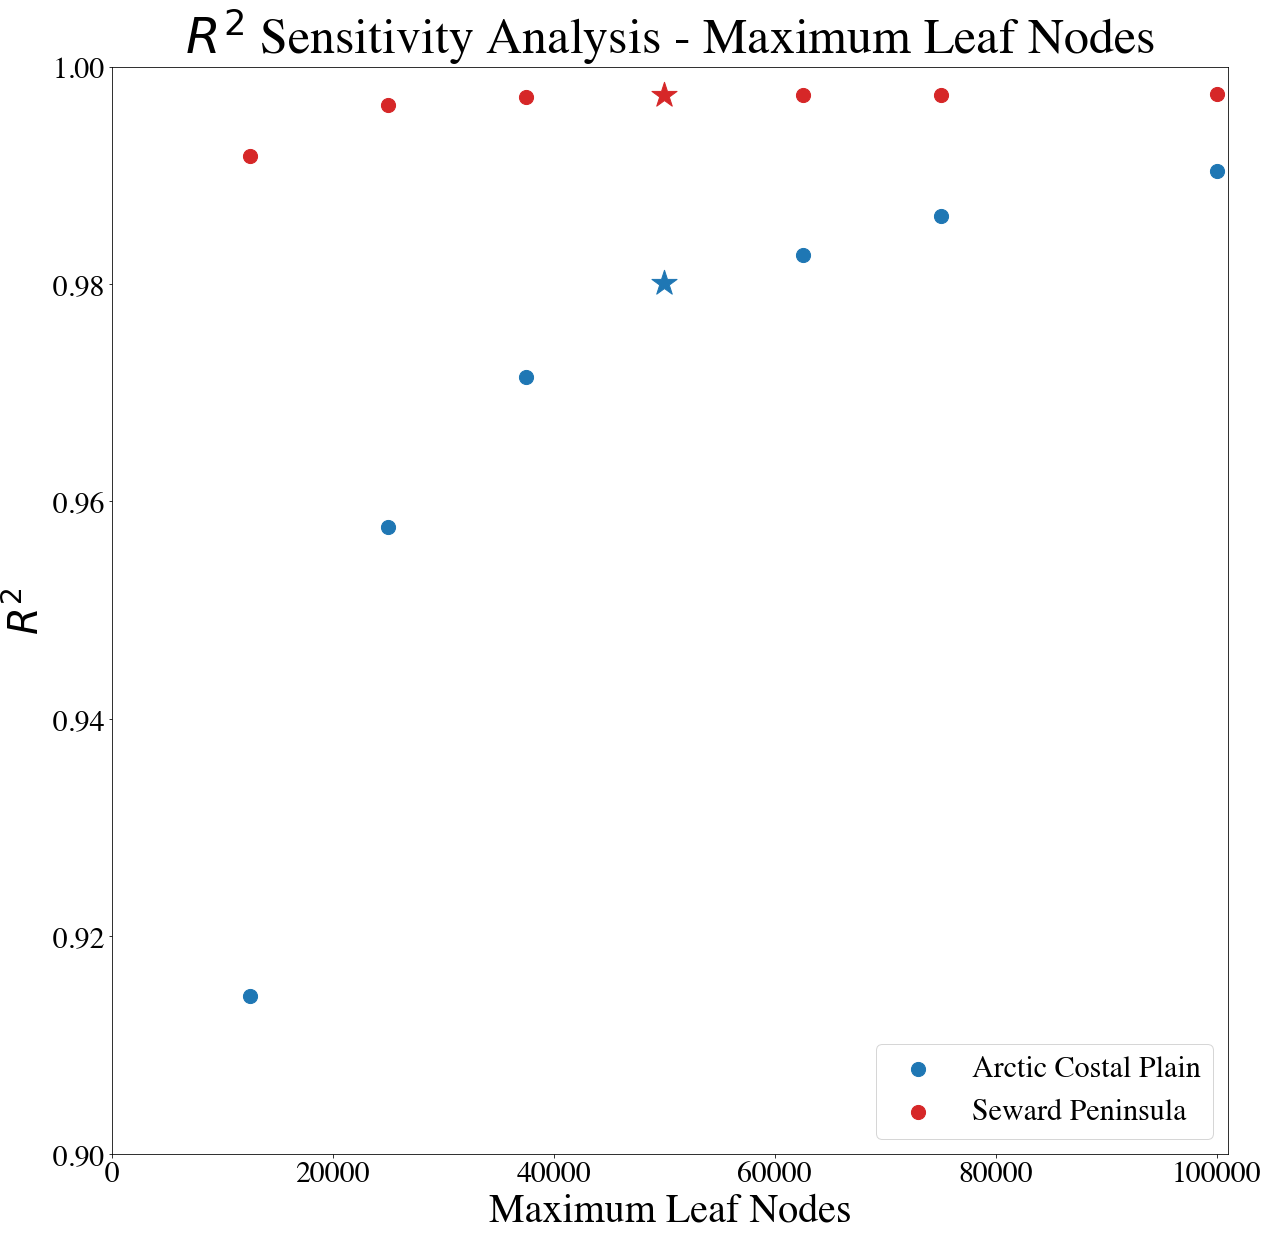

In [5]:
fig, ax = basic_r2_plot( 'mln', axis_bounds=[.9, 1, 0, 101000]) 
fig.savefig('../presentations/03/figures/mln-r2.png', transparent=True)

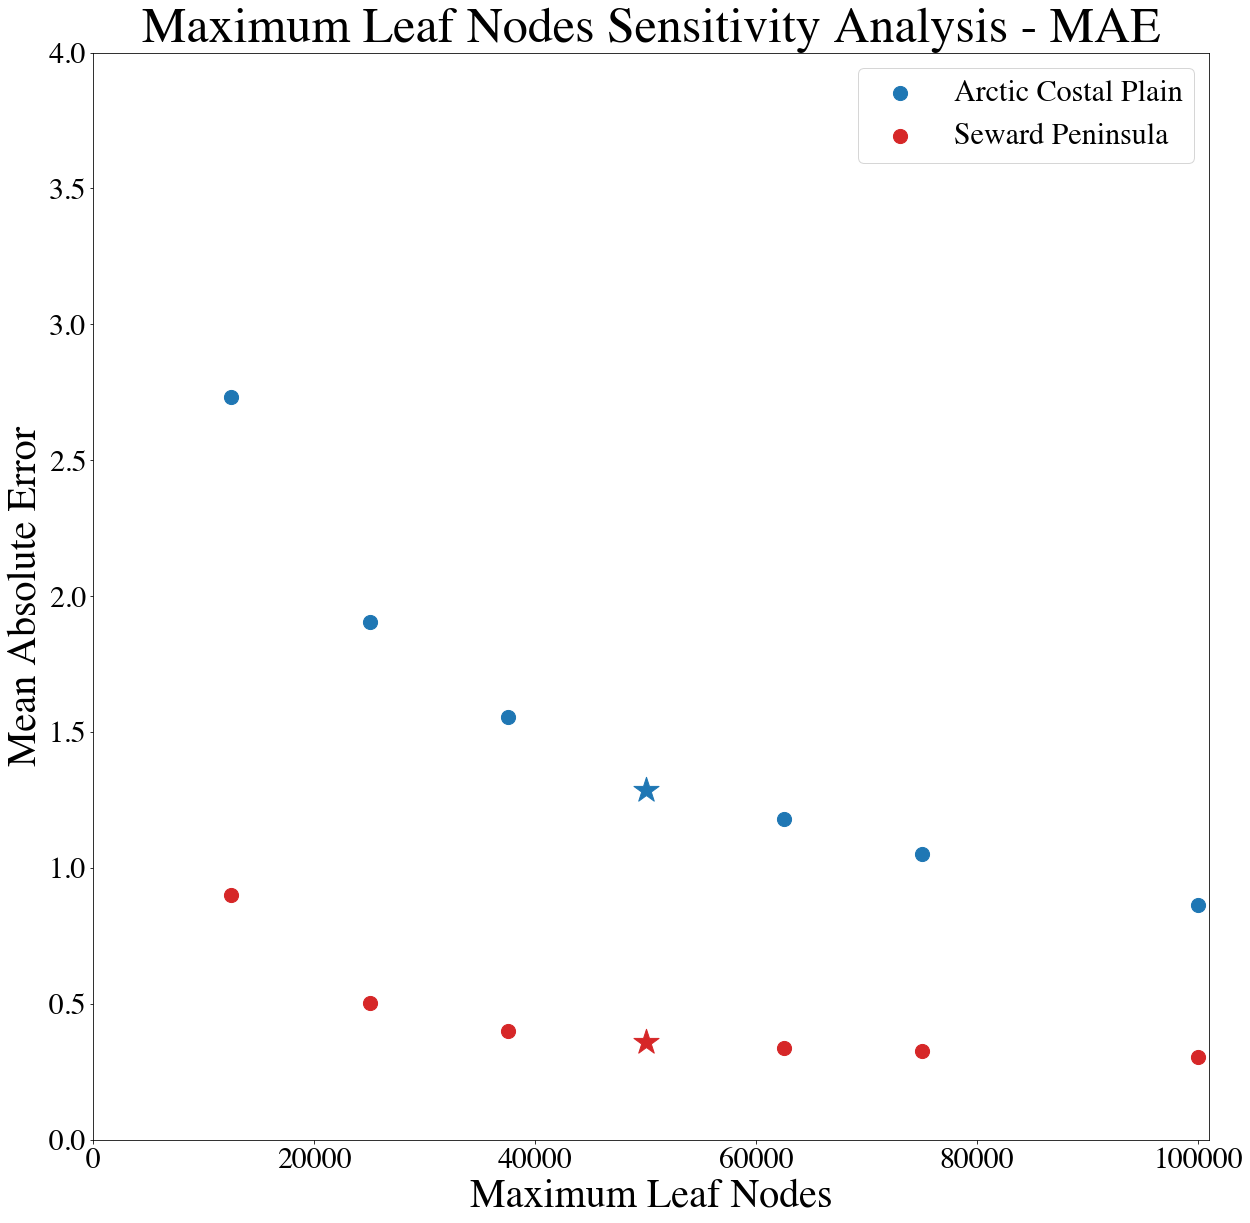

In [6]:
fig, ax = basic_mae_plot( 'mln', axis_bounds=[0, 4, 0, 101000])
fig.savefig('../presentations/03/figures/mln-mae.png', transparent=True)

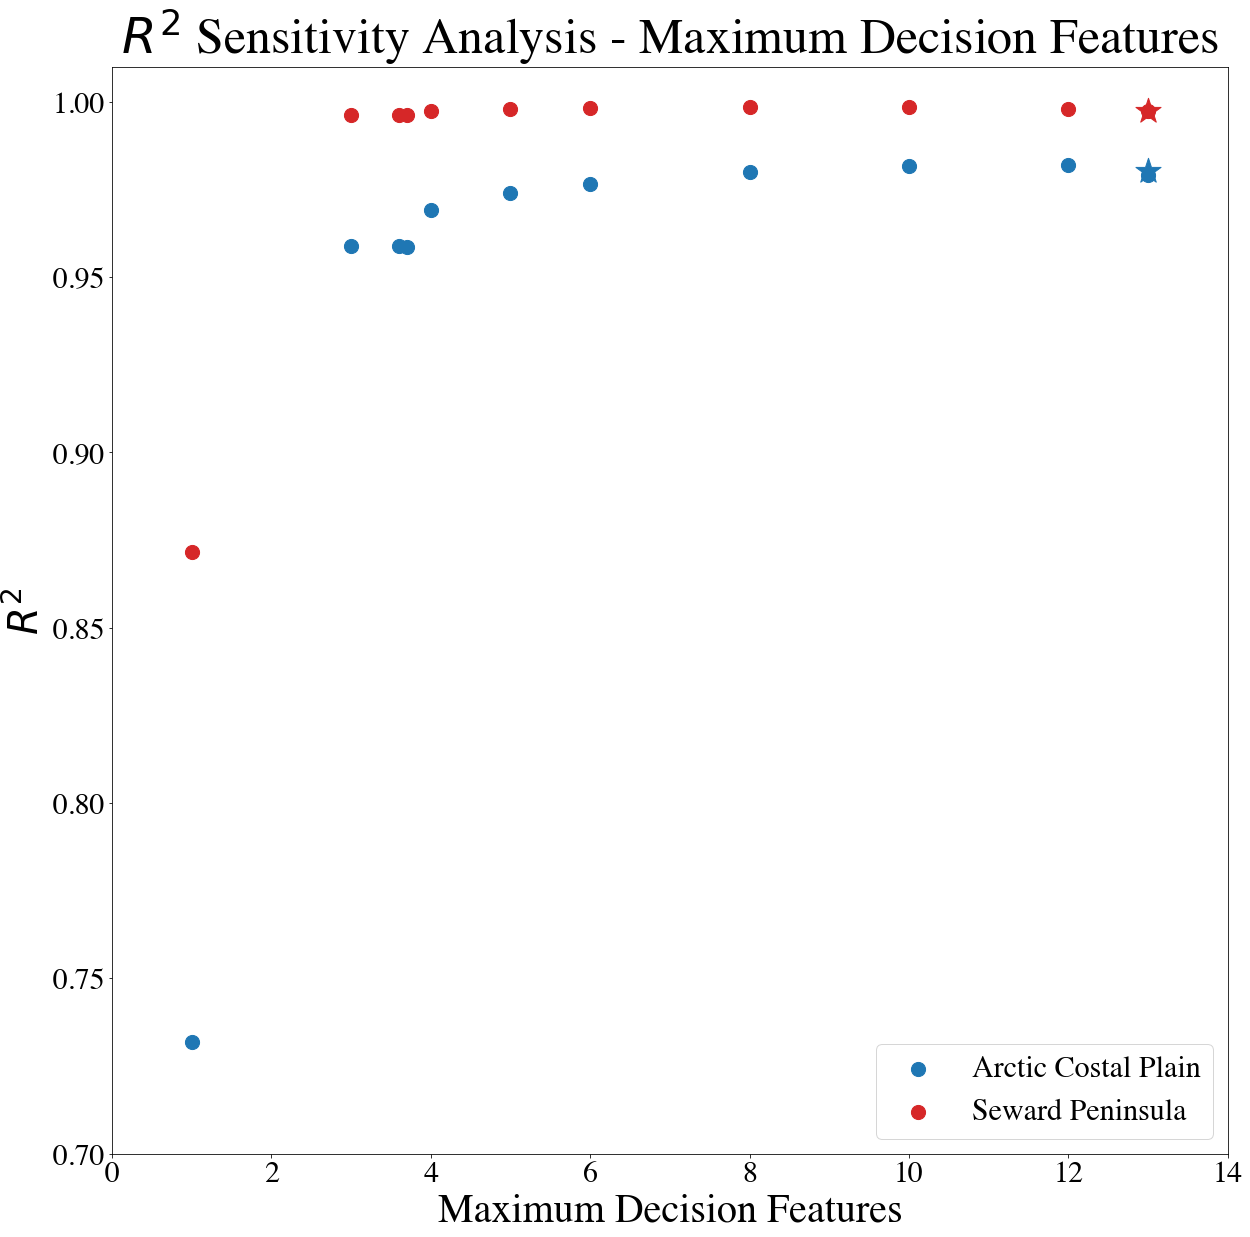

In [7]:
fig, ax = basic_r2_plot( 'mf2', axis_bounds=[.7, 1.01, 0, 14])
fig.savefig('../presentations/03/figures/mf-r2.png', transparent=True)

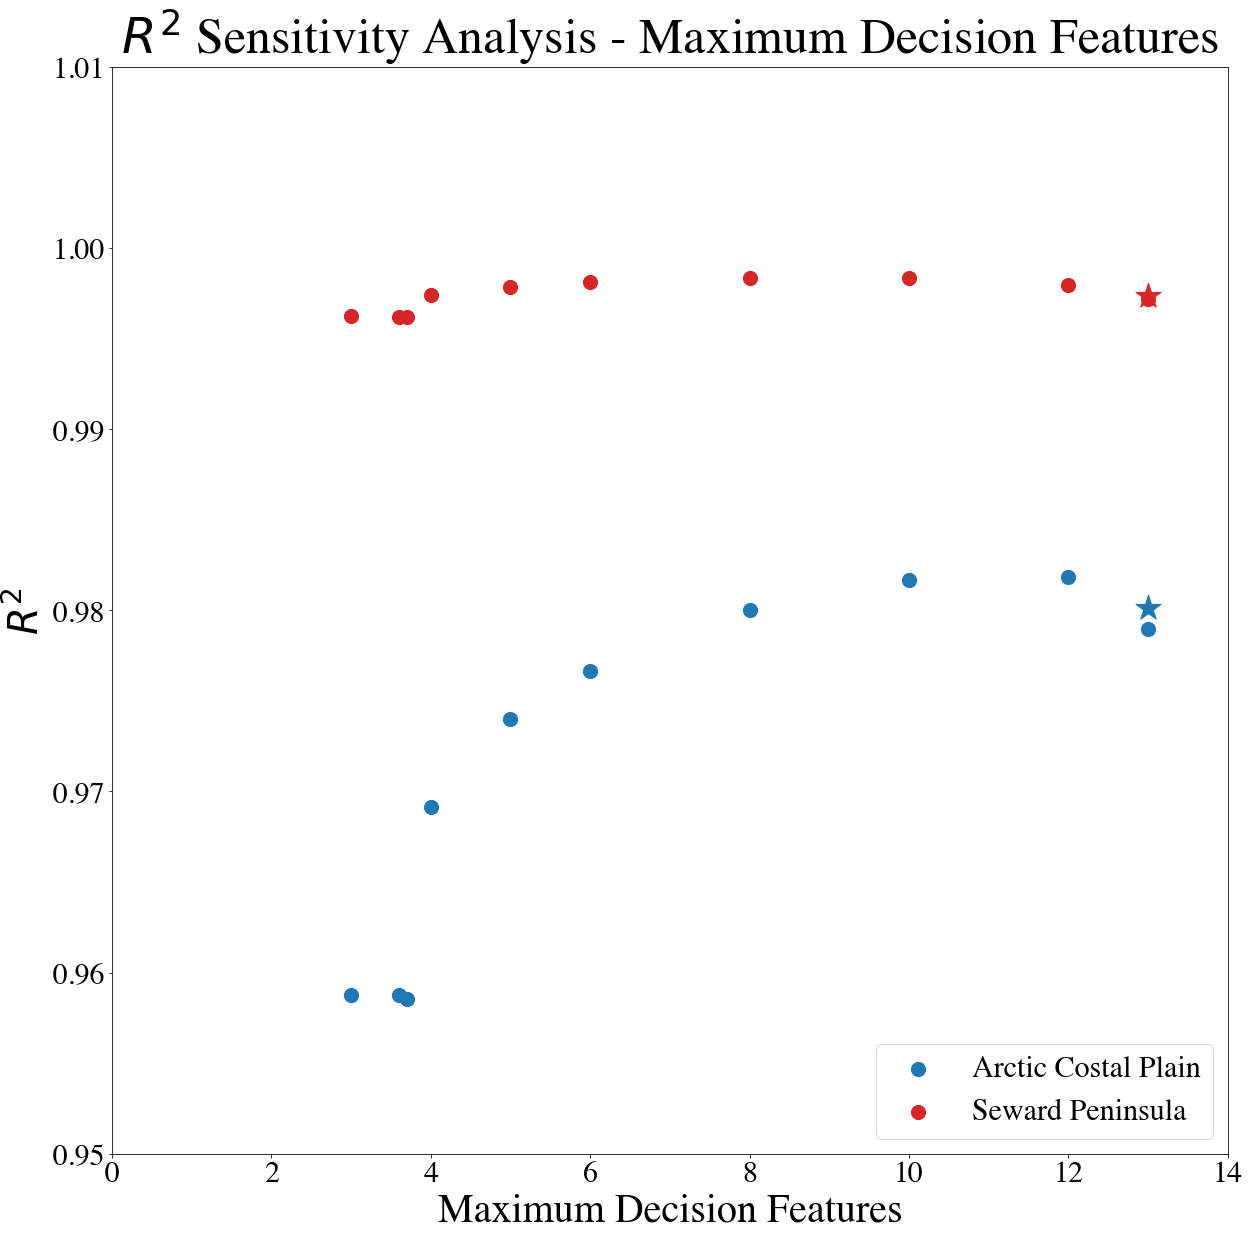

In [8]:
fig, ax = basic_r2_plot( 'mf2', axis_bounds=[.95, 1.01, 0, 14])
fig.savefig('../presentations/03/figures/mf-r2-zoom.png', transparent=True)

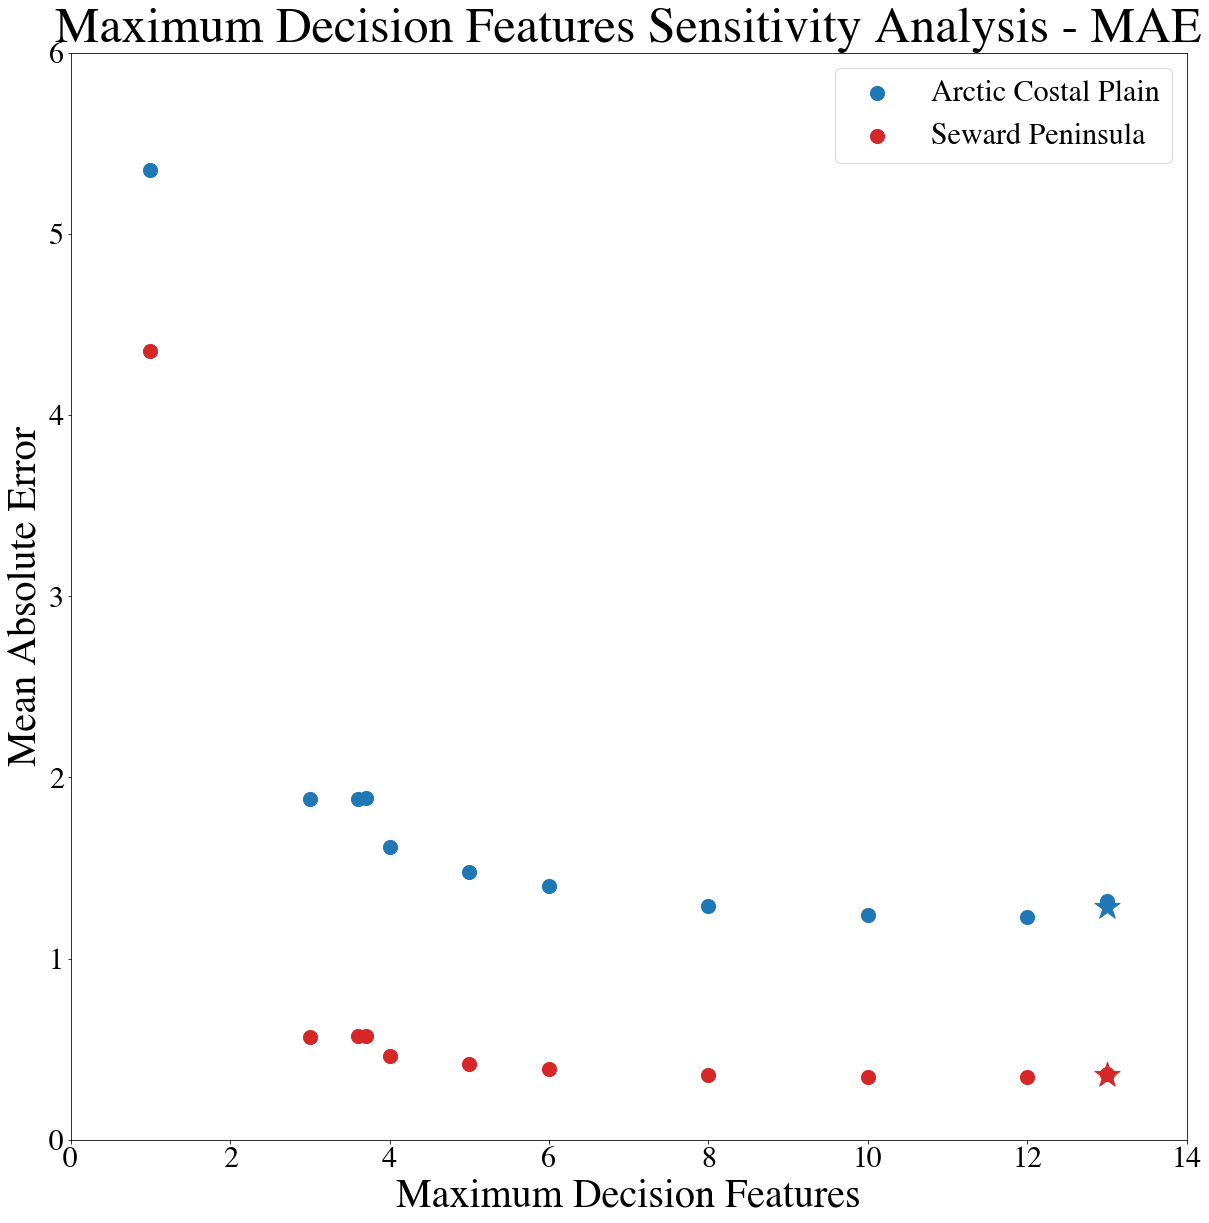

In [9]:
fig, ax = basic_mae_plot( 'mf2', axis_bounds=[0, 6, 0, 14])
fig.savefig('../presentations/03/figures/mf-mae.png', transparent=True)

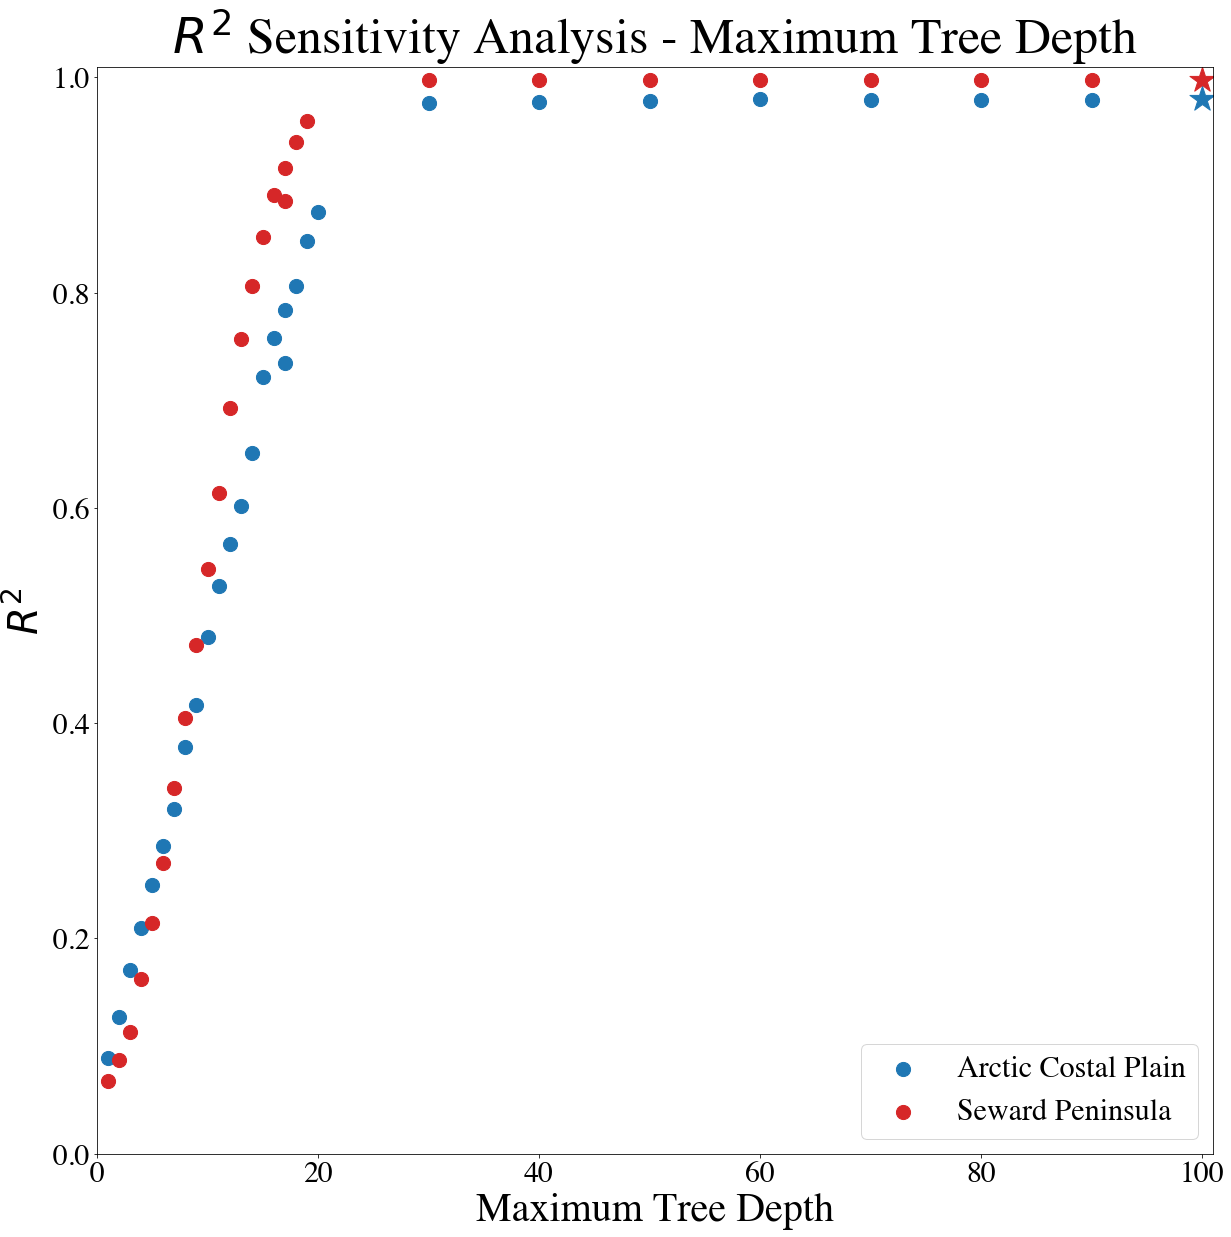

In [10]:
fig, ax = basic_r2_plot( 'md', axis_bounds=[0, 1.01, 0, 101])
fig.savefig('../presentations/03/figures/md-r2.png', transparent=True)

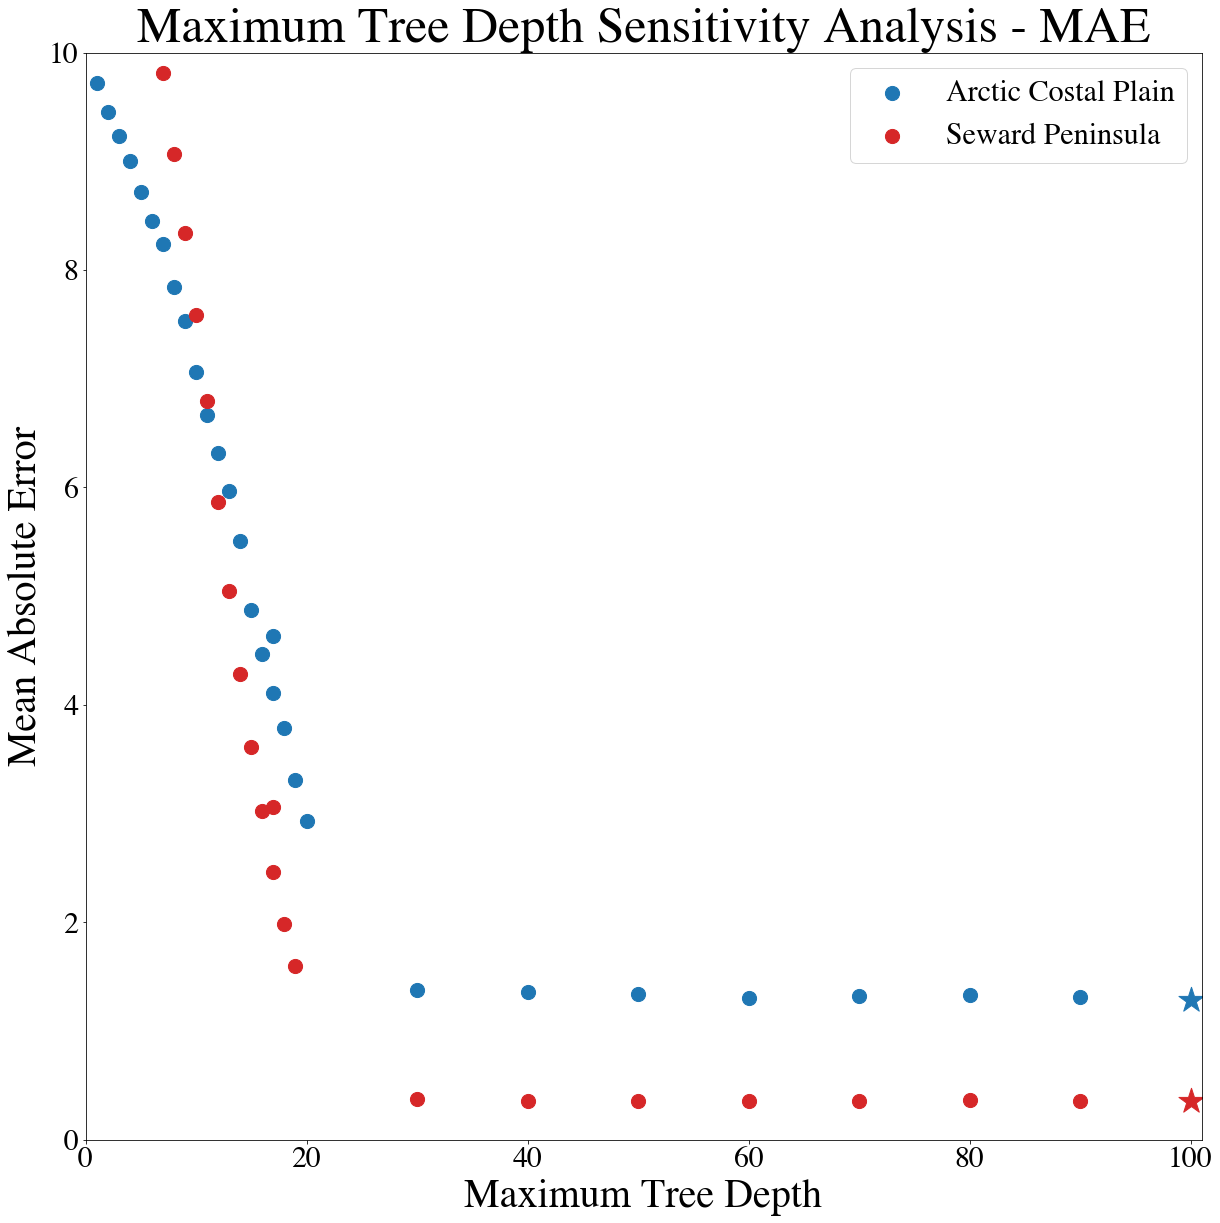

In [11]:
fig, ax = basic_mae_plot( 'md', axis_bounds=[0, 10, 0, 101])
fig.savefig('../presentations/03/figures/md-mae.png', transparent=True)

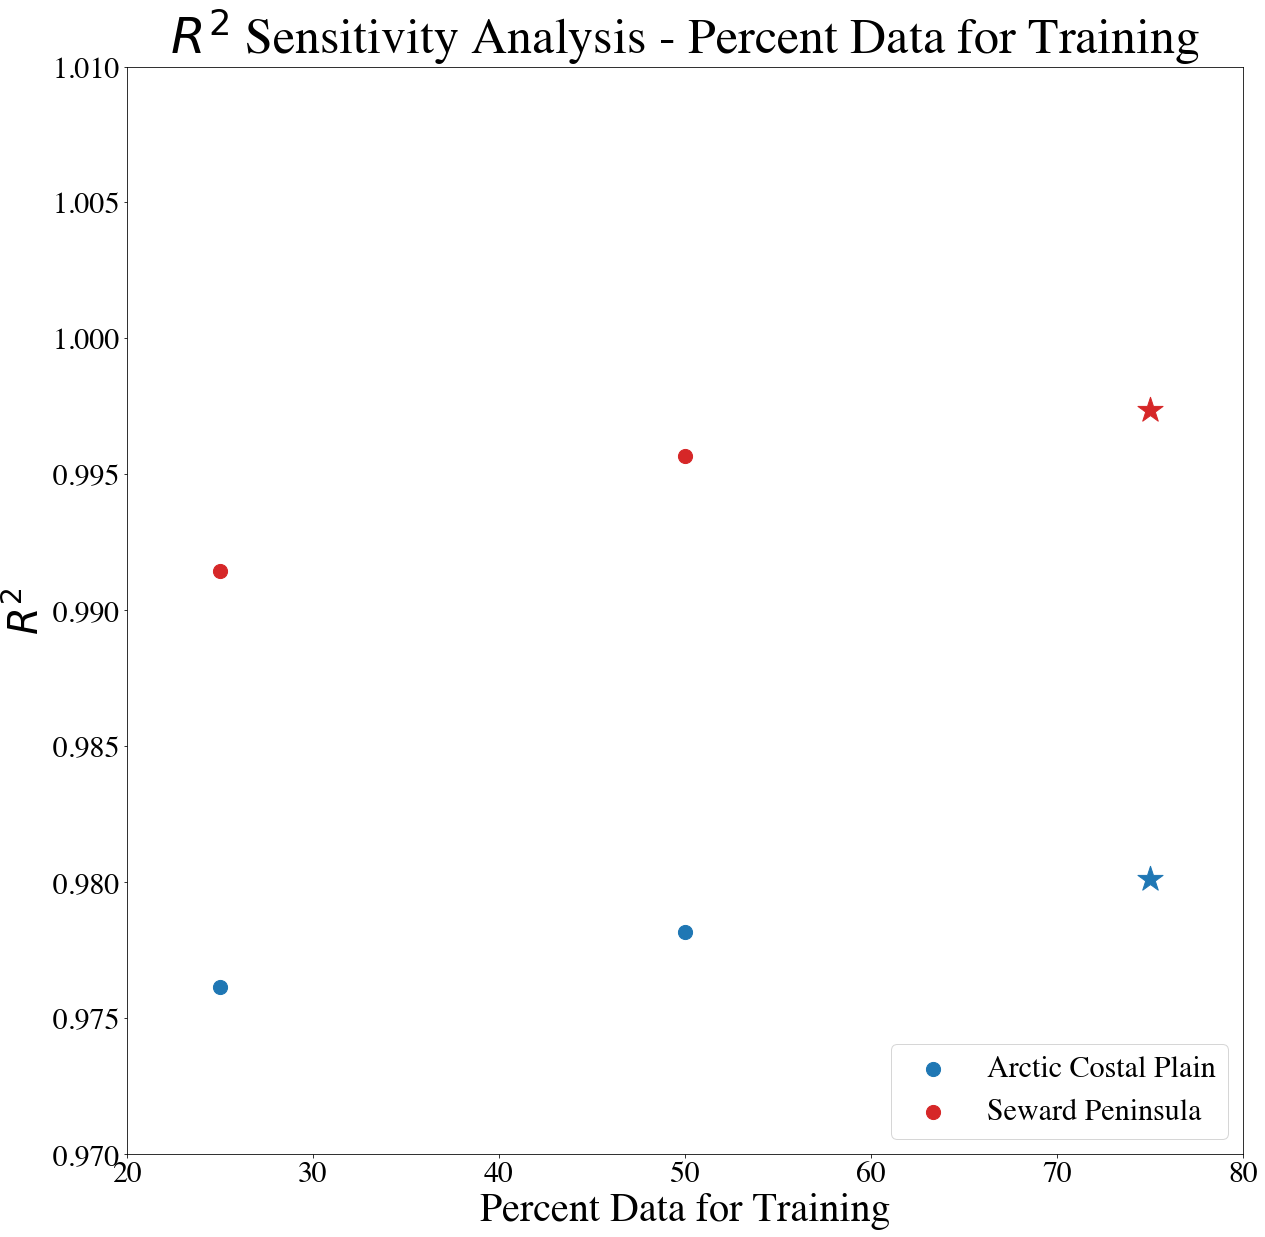

In [12]:
fig, ax = basic_r2_plot( 'tdp', axis_bounds=[.97, 1.01, 20, 80], legend_loc='lower right')
fig.savefig('../presentations/03/figures/tdp-r2.png', transparent=True)

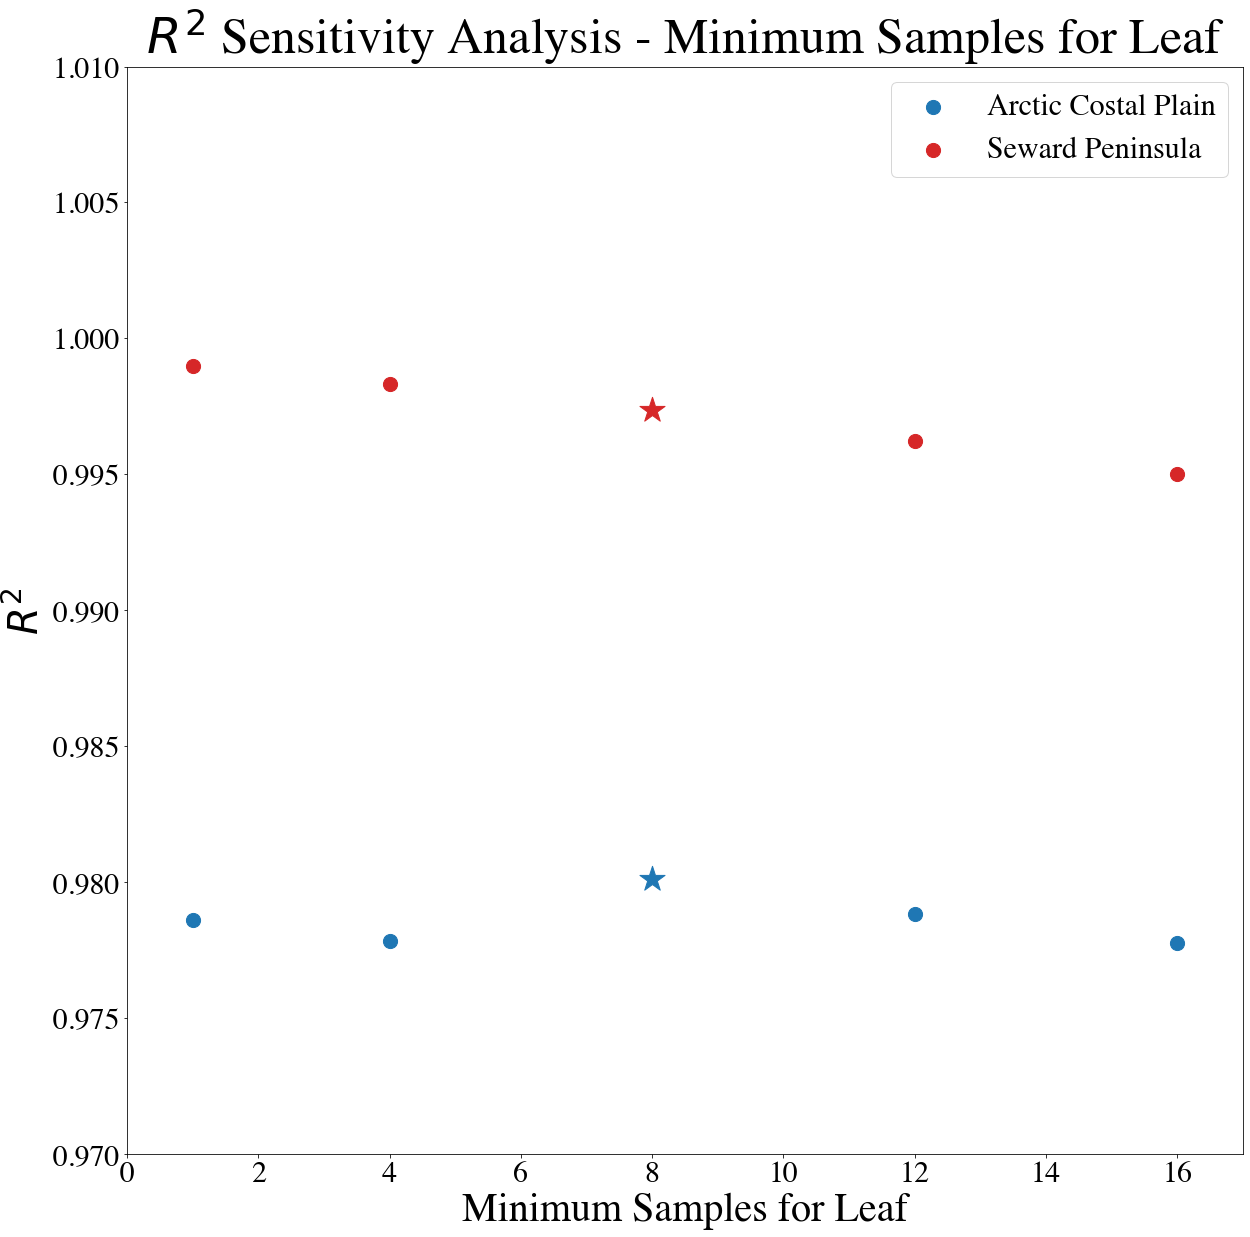

In [13]:
fig, ax = basic_r2_plot( 'msl', axis_bounds=[.97, 1.01, 0, 17], fig_size=(20,20), legend_loc='upper right')
fig.savefig('../presentations/03/figures/msl-r2.png', transparent=True)

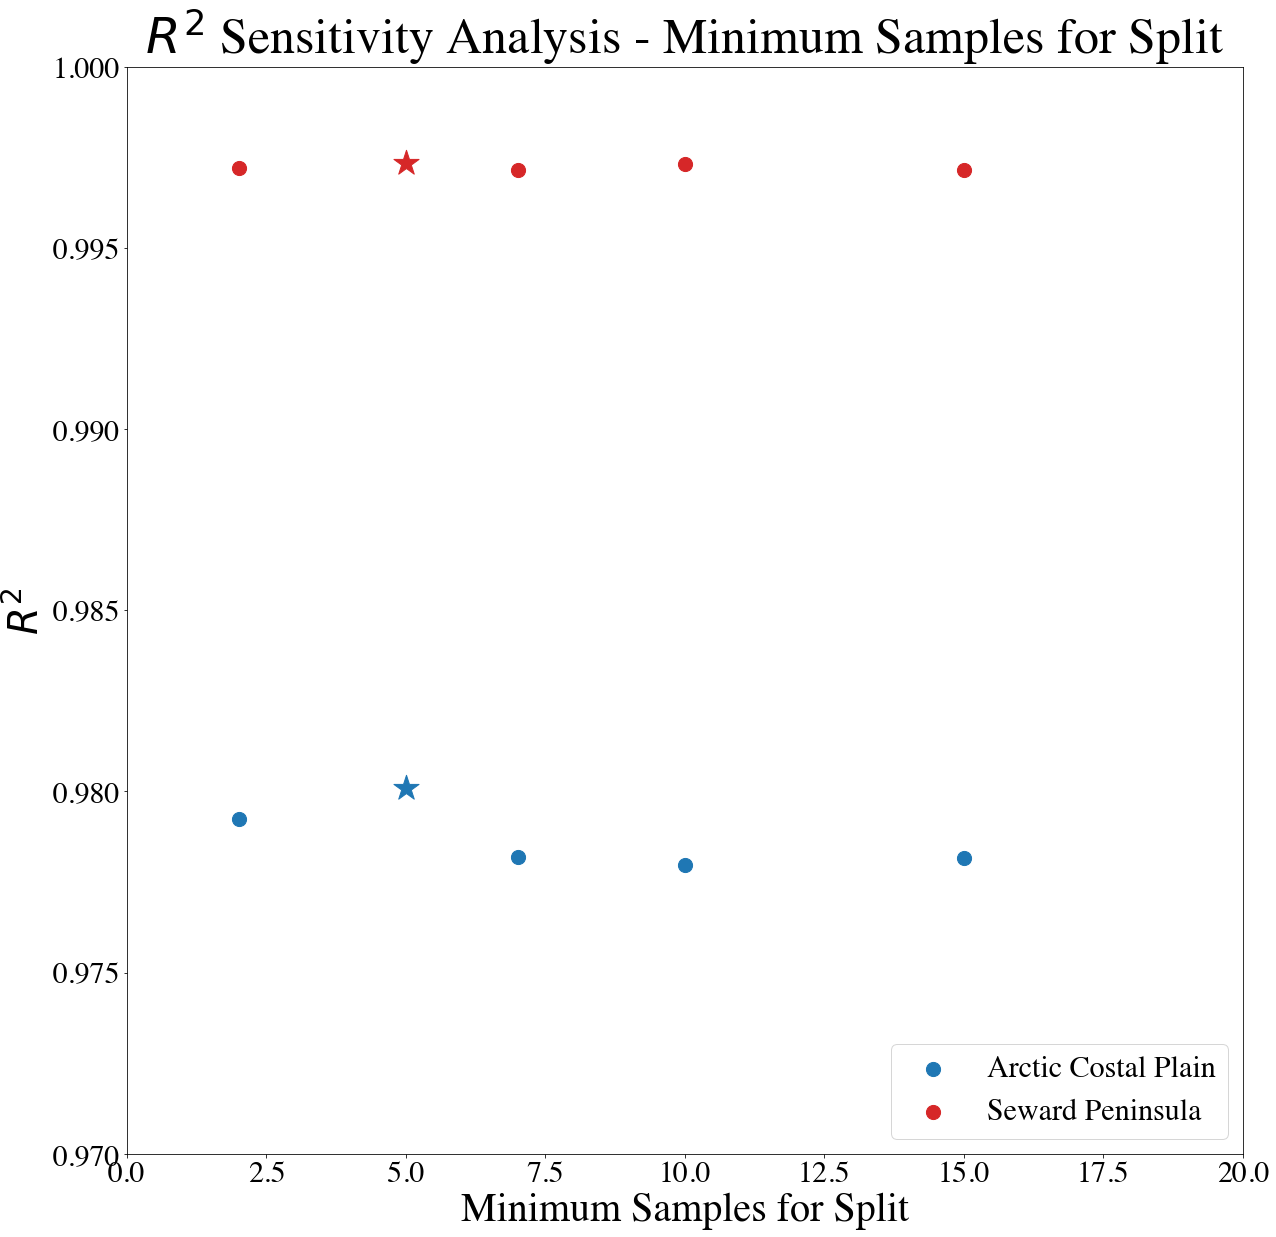

In [14]:
fig, ax = basic_r2_plot( 'mss', axis_bounds=[.97, 1, 0, 20])
fig.savefig('../presentations/03/figures/mss-r2.png', transparent=True)

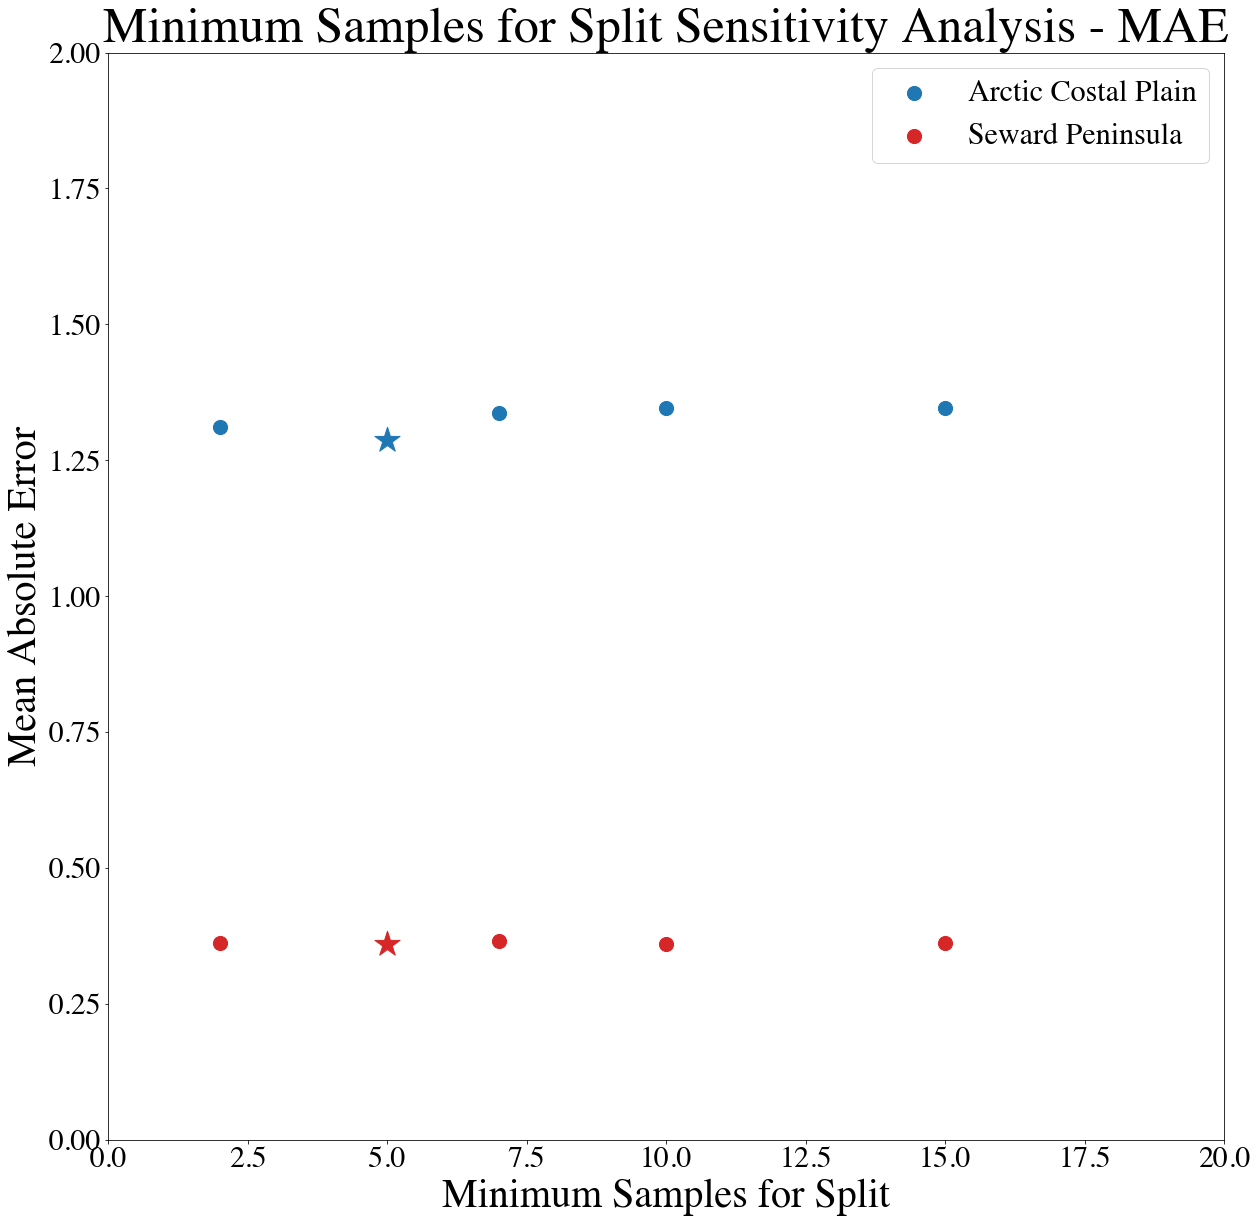

In [15]:
fig, ax = basic_mae_plot( 'mss', axis_bounds=[0, 2, 0, 20])
fig.savefig('../presentations/03/figures/mss-mae.png', transparent=True)

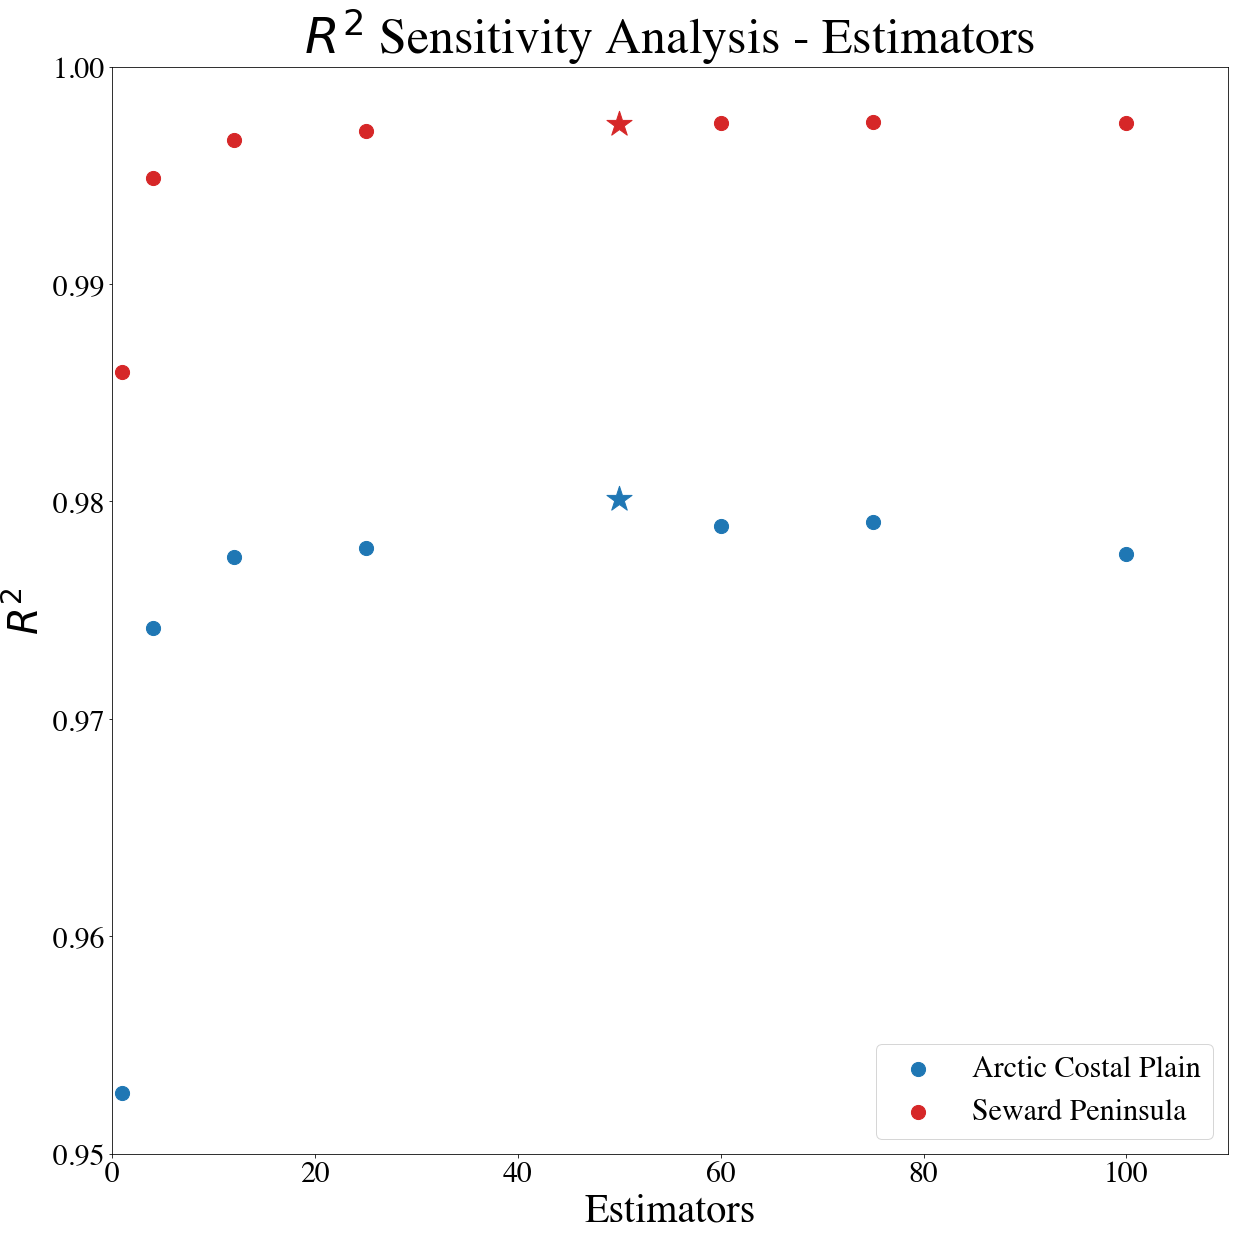

In [16]:
fig, ax = basic_r2_plot( 'e', axis_bounds=[.95, 1, 0, 110])
fig.savefig('../presentations/03/figures/e-r2.png', transparent=True)

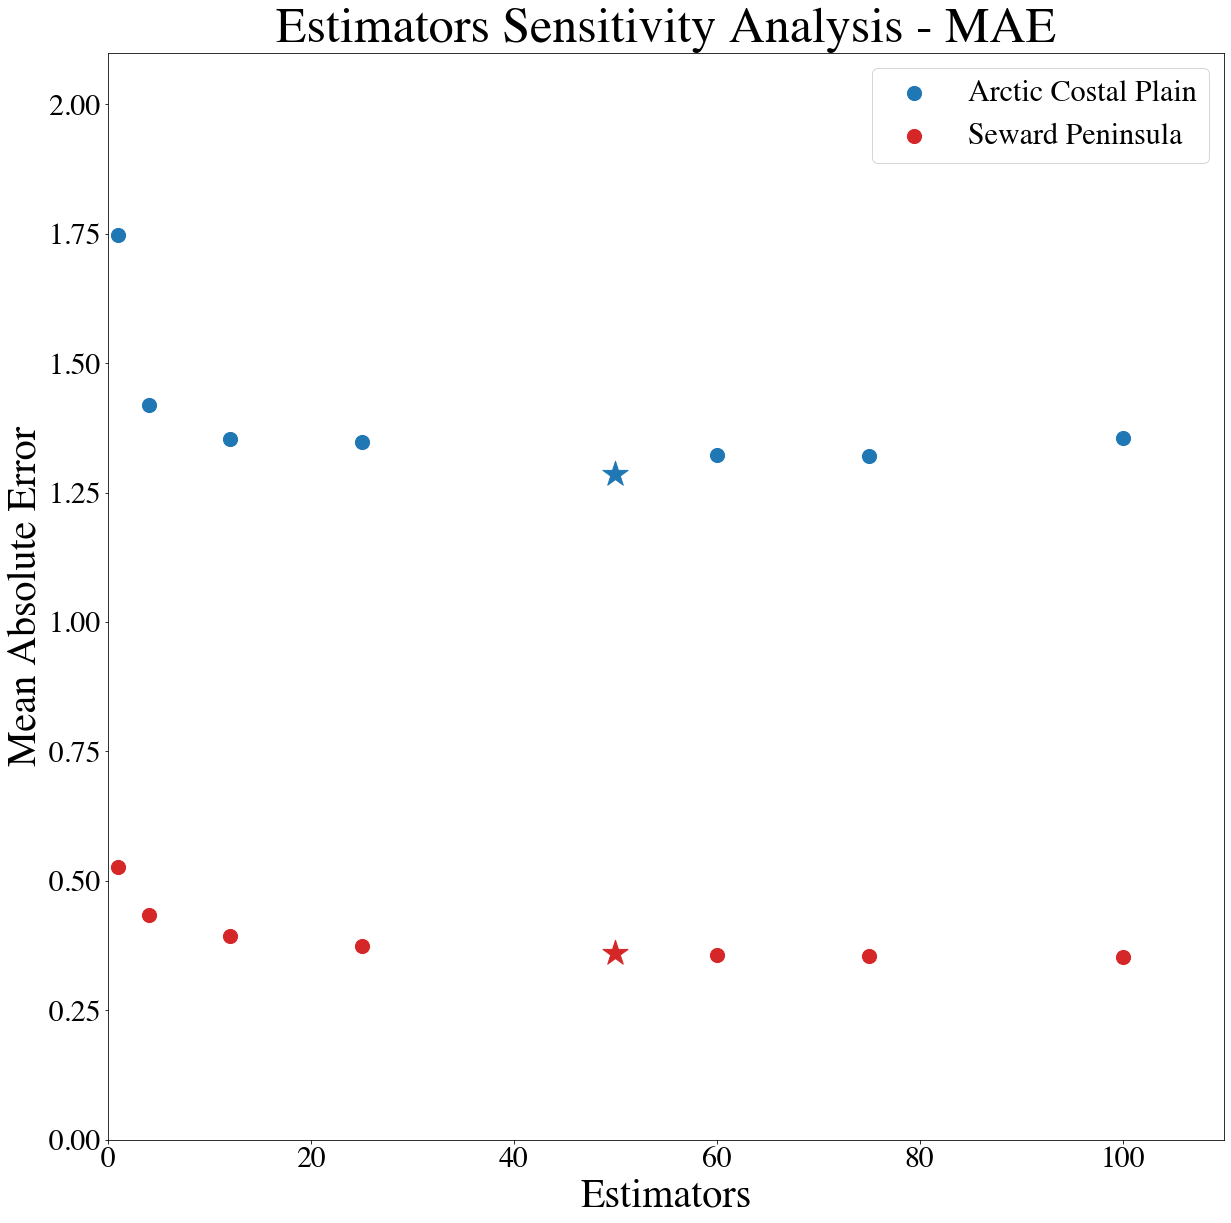

In [17]:
fig, ax = basic_mae_plot( 'e', axis_bounds=[0, 2.1, 0, 110])
fig.savefig('../presentations/03/figures/e-mae.png', transparent=True)

In [18]:
sp_stats[np.logical_or(sp_stats['hp_changed'] == 'mss', sp_stats['hp_changed'] == 'base')]


,features,mean_abs_error,mean_error,median_abs_error,median_error,predict_time,r2,train_time,var_abs_error,var_error,...,md,mf,mln,msl,mss,ms,tdp,hp_changed,mf2,e
SP-rf-training-set_rfm_e50_md100_mfAUTO_mln50000_msl8_mss2_tdp75.joblib,SP-rf-training-set.yml,0.362373,-0.002779,0.213042,0.004222,00:05.6,0.997197,09:44.0,0.602281,0.733587,...,100,auto,50000,8,2,None,75,mss,13.0,50
SP-rf-training-set_rfm_e50_md100_mfAUTO_mln50000_msl8_mss7_tdp75.joblib,SP-rf-training-set.yml,0.364747,-0.001840,0.213253,0.004457,00:05.8,0.997146,09:46.1,0.613814,0.746851,...,100,auto,50000,8,7,None,75,mss,13.0,50
SP-rf-training-set_rfm_e50_md100_mfAUTO_mln50000_msl8_mss10_tdp75.joblib,SP-rf-training-set.yml,0.360193,-0.002498,0.212274,0.004485,00:05.6,0.997299,10:02.5,0.577023,0.706755,...,100,auto,50000,8,10,None,75,mss,13.0,50
SP-rf-training-set_rfm_e50_md100_mfAUTO_mln50000_msl8_mss15_tdp75.joblib,SP-rf-training-set.yml,0.362692,-0.002356,0.212940,0.004943,00:05.8,0.997144,09:45.0,0.615740,0.747279,...,100,auto,50000,8,15,None,75,mss,13.0,50
SP-rf-training-set_rfm_e50_md100_mfAUTO_mln50000_msl8_mss25_tdp75.joblib,SP-rf-training-set.yml,0.368522,-0.002889,0.211251,0.005263,00:05.5,0.997091,09:47.5,0.625472,0.761273,...,100,auto,50000,8,25,None,75,mss,13.0,50
baseline_rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.joblib,SP-rf-training-set.yml,0.359765,-0.002667,0.212771,0.004951,00:05.6,0.997348,09:43.4,0.564512,0.693936,...,100,auto,50000,8,5,None,75,base,13.0,50


In [19]:
acp_stats[np.logical_or(acp_stats['hp_changed'] == 'mss', acp_stats['hp_changed'] == 'base')]

,features,mean_abs_error,mean_error,median_abs_error,median_error,predict_time,r2,train_time,var_abs_error,var_error,...,estimators,md,mf,mln,msl,mss,ms,tdp,mf2,e
ACP-training-base_rfm_e50_md100_mfAUTO_mln50000_msl8_mss2_tdp75.joblib,ACP-training-base.yml,1.311087,-0.003867,0.853271,0.017905,00:41.8,0.979241,59:50.5,2.253867,3.972802,...,50,100,auto,50000,8,2,None,75,13.0,50
ACP-training-base_rfm_e50_md100_mfAUTO_mln50000_msl8_mss7_tdp75.joblib,ACP-training-base.yml,1.337084,-0.003396,0.869136,0.019100,00:41.9,0.978183,59:58.3,2.387356,4.175138,...,50,100,auto,50000,8,7,None,75,13.0,50
ACP-training-base_rfm_e50_md100_mfAUTO_mln50000_msl8_mss10_tdp75.joblib,ACP-training-base.yml,1.346007,-0.004145,0.875596,0.017578,00:41.8,0.977961,59:48.5,2.405946,4.217664,...,50,100,auto,50000,8,10,None,75,13.0,50
ACP-training-base_rfm_e50_md100_mfAUTO_mln50000_msl8_mss15_tdp75.joblib,ACP-training-base.yml,1.345533,-0.003534,0.877991,0.017517,00:42.0,0.978163,59:55.8,2.368593,4.179039,...,50,100,auto,50000,8,15,None,75,13.0,50
ACP-training-base_rfm_e50_md100_mfAUTO_mln50000_msl8_mss25_tdp75.joblib,ACP-training-base.yml,1.337166,-0.003690,0.869689,0.018985,00:41.3,0.978185,59:51.9,2.386770,4.174768,...,50,100,auto,50000,8,25,None,75,13.0,50
BASELINE_rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml,ACP-training-base.yml,1.286564,-0.004368,0.833219,0.018465,NaN,0.980101,169.4,2.152947,3.808173,...,50,100,auto,50000,8,5,None,75,13.0,50
